In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

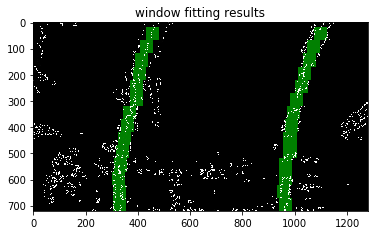

In [3]:
from convolution import window_mask, find_window_centroids
from sliding_window import fit_polynomial

In [4]:
cmt, diss = np.load('./cmx_dist.npy')
M, Minv = np.load('./M_Minv.npy')

In [5]:
# combine each thresh
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel_image = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel_image = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absolute_sobel = np.absolute(sobel_image)
    scale_sobel = np.uint8(255 * absolute_sobel / np.max(absolute_sobel))
    grad_binary = np.zeros_like(scale_sobel)
    grad_binary[(scale_sobel > thresh[0]) & (scale_sobel < thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale = np.uint8(gradmag * 255 / np.max(gradmag))
    mag_binary = np.zeros_like(scale)
    mag_binary[(scale >= mag_thresh[0]) & (scale <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [6]:
def threshold(image):
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, 'x', ksize, (10, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, ksize, (1.2, 1.9))
    HLS_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = HLS_image[:, :, 2]
    # combined thresholds
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) & (mag_binary == 1)] = 1
    thresh = (90, 255)
    combined[(S > thresh[0]) & (S <= thresh[1])] = 1
    return combined

def conv(warped):
    window_width = 50 
    window_height = 50 # Break image into 9 vertical layers since image height is 720
    margin = 50 # How much to slide left and right for searching
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.uint8(np.dstack((warped, warped, warped))*255) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    return output

In [7]:
%pdb

Automatic pdb calling has been turned ON


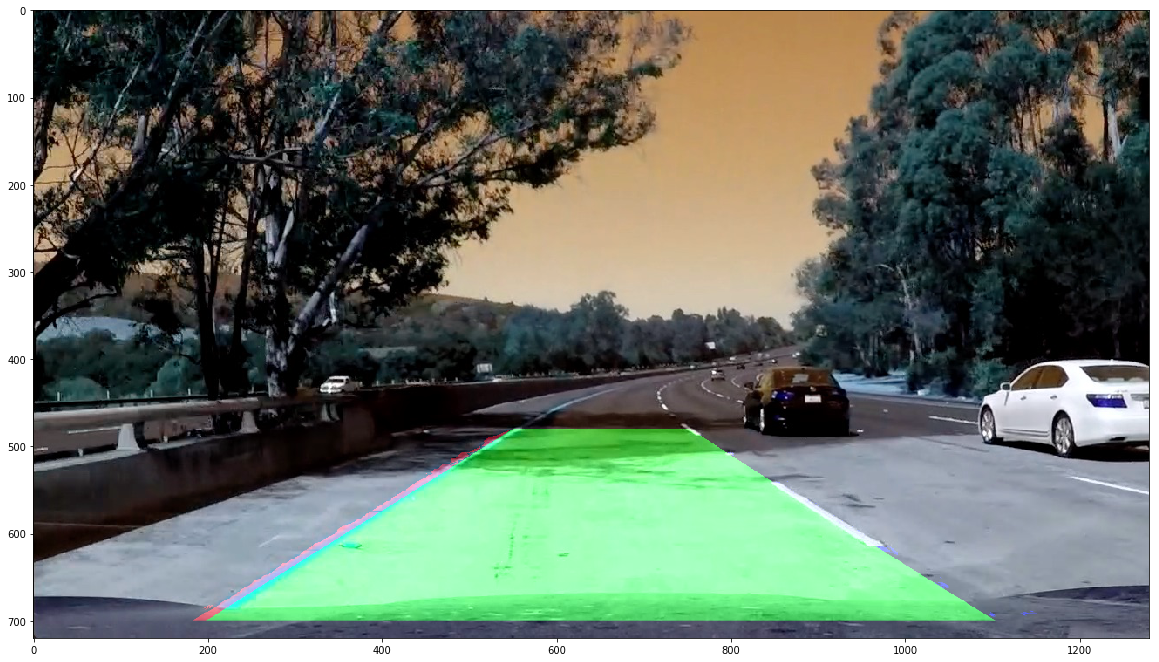

In [8]:
def pipeline(img):
    original_img = img
    img = cv2.warpPerspective(cv2.undistort(img, cmt, diss), M, (1280, 720))
    img = threshold(img)
    img, x1, x2 = fit_polynomial(img)
    pts_left = np.array([np.transpose(np.vstack(x1))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack(x2)))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(img, np.int_([pts]), (0,255, 0))
    # img = conv(img)
    img = cv2.warpPerspective(img, Minv, (1280, 720))
    img = cv2.addWeighted(original_img, 1, img.astype(np.uint8), 0.5, 0)
    return img
plt.figure(figsize=(20, 20))
plt.imshow(pipeline(cv2.imread('./test_images/test5.jpg')))

In [ ]:
project_video = './project_video.mp4'
clip = VideoFileClip(project_video)
white_clip = clip.fl_image(image_func=pipeline)
white_clip.write_videofile('project_test.mp4', audio=False)

[MoviePy] >>>> Building video project_test.mp4
[MoviePy] Writing video project_test.mp4


 25%|██▍       | 310/1261 [01:29<04:35,  3.45it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_test.mp4'))